***LDA With Random Forest Classifier***

***LDA With Random Forest Classifier (Seperate)***


In [323]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import torch
from torchvision import datasets, transforms

In [325]:
# New: Modified data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),  # New: Reduced rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # New: Reduced color jitter
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # New: ImageNet normalization
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [327]:
batch_size = 64

In [329]:
# Load the datasets with these transformations
data_dir = r'C:\Users\admin\Downloads\datasets-20240824T023713Z-001\datasets'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

Dataset sizes: {'train': 974, 'val': 209, 'test': 214}
Class names: ['Jennie', 'Jisoo', 'Lisa', 'Rose']


In [331]:
def preprocess_data(dataloader):
    images = []
    labels = []
    for batch in dataloader:
        inputs, targets = batch
        inputs = inputs.cpu()
        targets = targets.cpu()
        images.extend(inputs.view(inputs.size(0), -1).numpy())
        labels.extend(targets.numpy())
    return np.array(images), np.array(labels)

In [333]:
# Preprocess all datasets
X_train, y_train = preprocess_data(dataloaders['train'])
X_val, y_val = preprocess_data(dataloaders['val'])
X_test, y_test = preprocess_data(dataloaders['test'])

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (974, 150528)
Shape of y_train: (974,)
Shape of X_val: (209, 150528)
Shape of y_val: (209,)
Shape of X_test: (214, 150528)
Shape of y_test: (214,)


In [334]:
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

Number of classes: 4


In [335]:
# New: Modified LDA implementation
lda = LDA(n_components=min(num_classes - 1, 100))  # New: Limit to 100 components
X_train_lda = lda.fit_transform(X_train, y_train)
X_val_lda = lda.transform(X_val)
X_test_lda = lda.transform(X_test)

In [336]:
# New: Print explained variance ratio
print(f"Explained variance ratio: {sum(lda.explained_variance_ratio_):.4f}")

Explained variance ratio: 1.0000


In [337]:
# New: Modified Random Forest parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [338]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                           param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train_lda, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Use the best estimator
best_rf_classifier = grid_search.best_estimator_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found:  {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best score found:  0.9763785355537934


In [339]:
def evaluate_model(model, X, y, class_names, dataset_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(f"{dataset_name} Accuracy: {accuracy:.4f}")
    print(f"{dataset_name} Classification Report:")
    print(classification_report(y, y_pred, target_names=class_names))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy


Best Random Forest Model Evaluation:
Train Accuracy: 0.9908
Train Classification Report:
              precision    recall  f1-score   support

      Jennie       0.98      0.99      0.99       305
       Jisoo       1.00      1.00      1.00       201
        Lisa       1.00      1.00      1.00       249
        Rose       0.99      0.97      0.98       219

    accuracy                           0.99       974
   macro avg       0.99      0.99      0.99       974
weighted avg       0.99      0.99      0.99       974



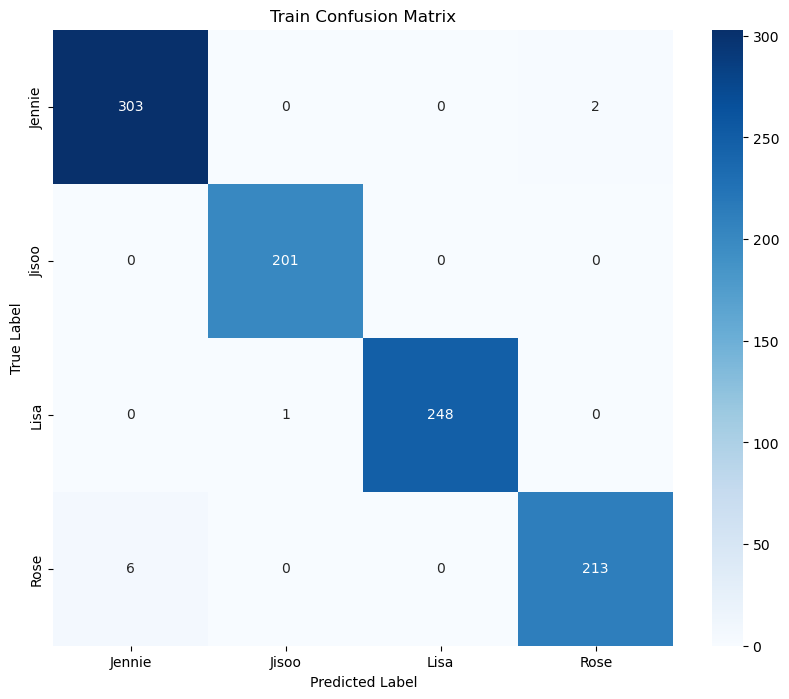

Validation Accuracy: 0.2536
Validation Classification Report:
              precision    recall  f1-score   support

      Jennie       0.43      0.14      0.21        65
       Jisoo       0.19      0.35      0.24        43
        Lisa       0.19      0.23      0.21        53
        Rose       0.39      0.35      0.37        48

    accuracy                           0.25       209
   macro avg       0.30      0.27      0.26       209
weighted avg       0.31      0.25      0.25       209



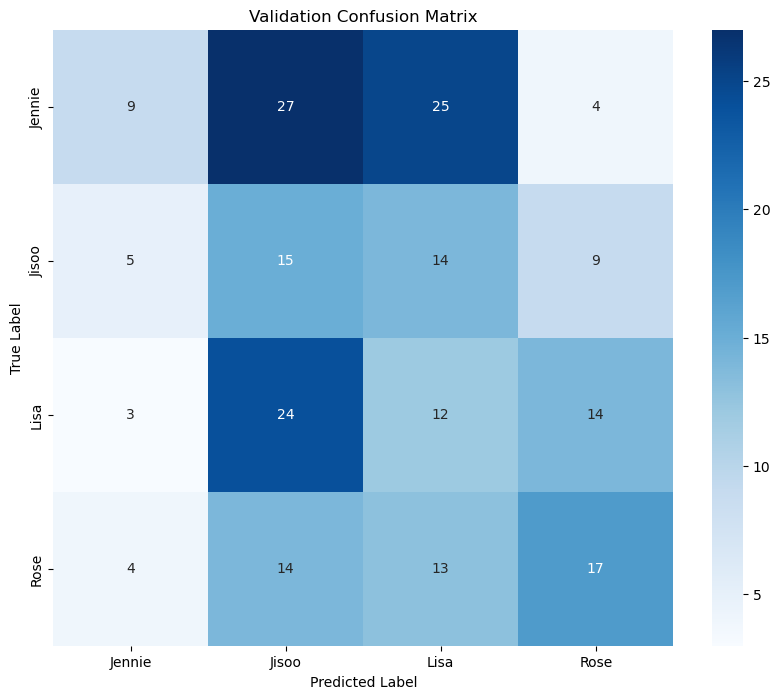

Test Accuracy: 0.2664
Test Classification Report:
              precision    recall  f1-score   support

      Jennie       0.32      0.09      0.14        67
       Jisoo       0.24      0.52      0.33        44
        Lisa       0.36      0.40      0.38        55
        Rose       0.15      0.12      0.14        48

    accuracy                           0.27       214
   macro avg       0.27      0.28      0.25       214
weighted avg       0.28      0.27      0.24       214



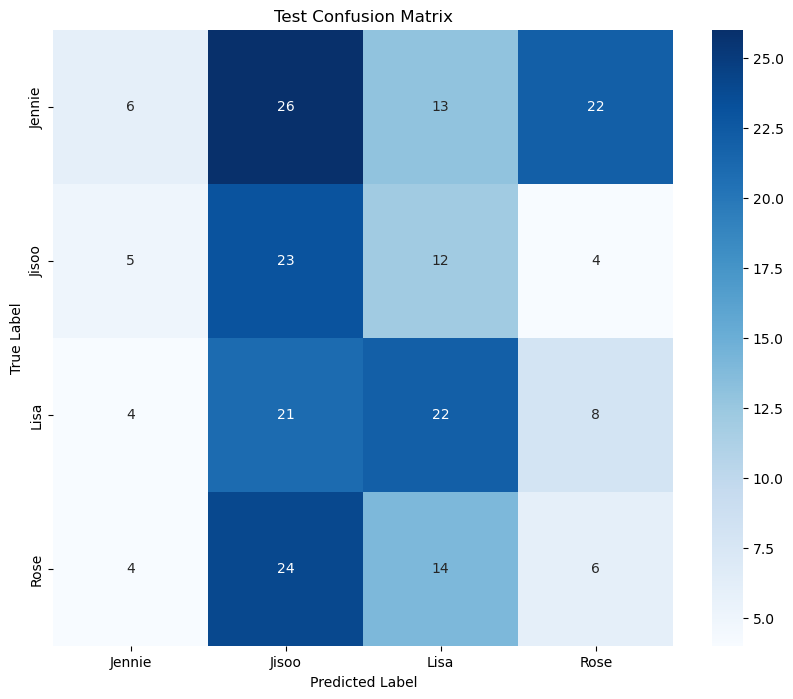


Cross-validation scores: [0.98974359 0.97435897 0.97948718 0.96923077 0.96907216]
Mean CV score: 0.9764 (+/- 0.0154)

Final Accuracies:
  Train: 0.9908
  Validation: 0.2536
  Test: 0.2664


In [340]:
# Evaluate best model after hyperparameter tuning
print("\nBest Random Forest Model Evaluation:")
train_acc_best = evaluate_model(best_rf_classifier, X_train_lda, y_train, class_names, "Train")
val_acc_best = evaluate_model(best_rf_classifier, X_val_lda, y_val, class_names, "Validation")
test_acc_best = evaluate_model(best_rf_classifier, X_test_lda, y_test, class_names, "Test")

# New: Cross-validation
cv_scores = cross_val_score(best_rf_classifier, X_train_lda, y_train, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Print accuracies
print("\nFinal Accuracies:")
print(f"  Train: {train_acc_best:.4f}")
print(f"  Validation: {val_acc_best:.4f}")
print(f"  Test: {test_acc_best:.4f}")

 ## ***LDA with Random Forest Classifier (1)***

Dataset sizes: {'train': 974, 'val': 209, 'test': 214}
Class names: ['Jennie', 'Jisoo', 'Lisa', 'Rose']
Shape of X_train: (974, 150528)
Shape of y_train: (974,)
Shape of X_val: (209, 150528)
Shape of y_val: (209,)
Shape of X_test: (214, 150528)
Shape of y_test: (214,)
Number of classes: 4
Explained variance ratio: 1.0000
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best score found:  0.8983875231297912

Best Random Forest Model Evaluation:
Train Accuracy: 0.9466
Train Classification Report:
              precision    recall  f1-score   support

      Jennie       0.95      0.95      0.95       305
       Jisoo       0.93      0.95      0.94       201
        Lisa       0.96      0.95      0.96       249
        Rose       0.94      0.93      0.94       219

    accuracy                           0.95       974
   macro avg       0.95 

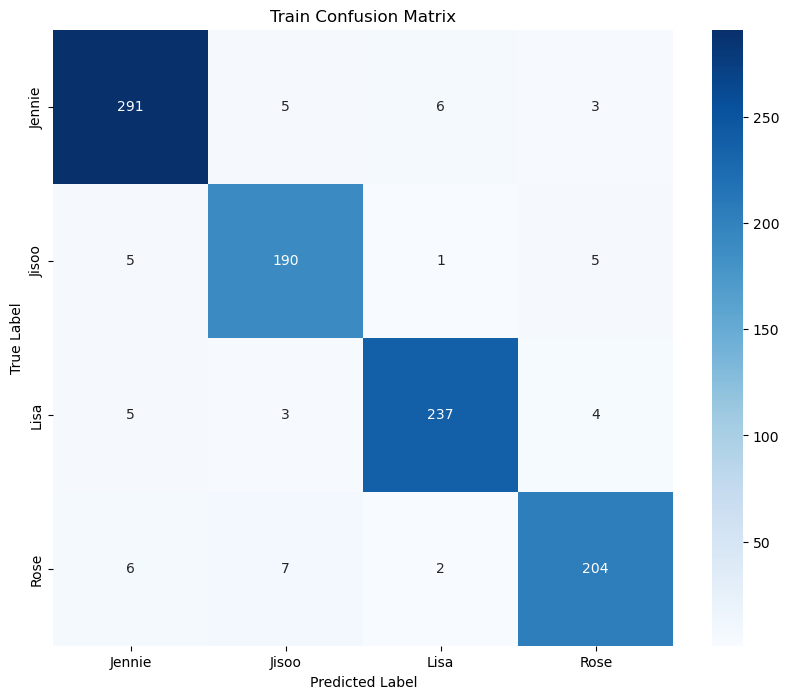

Validation Accuracy: 0.2775
Validation Classification Report:
              precision    recall  f1-score   support

      Jennie       0.33      0.29      0.31        65
       Jisoo       0.19      0.14      0.16        43
        Lisa       0.26      0.38      0.31        53
        Rose       0.30      0.27      0.29        48

    accuracy                           0.28       209
   macro avg       0.27      0.27      0.27       209
weighted avg       0.28      0.28      0.27       209



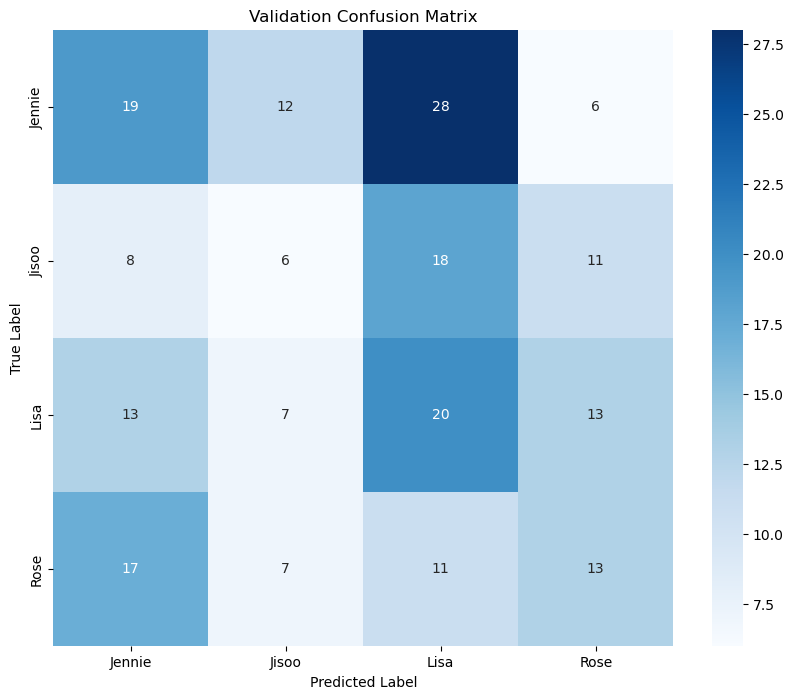

Test Accuracy: 0.3037
Test Classification Report:
              precision    recall  f1-score   support

      Jennie       0.32      0.31      0.32        67
       Jisoo       0.36      0.20      0.26        44
        Lisa       0.30      0.35      0.32        55
        Rose       0.26      0.33      0.29        48

    accuracy                           0.30       214
   macro avg       0.31      0.30      0.30       214
weighted avg       0.31      0.30      0.30       214



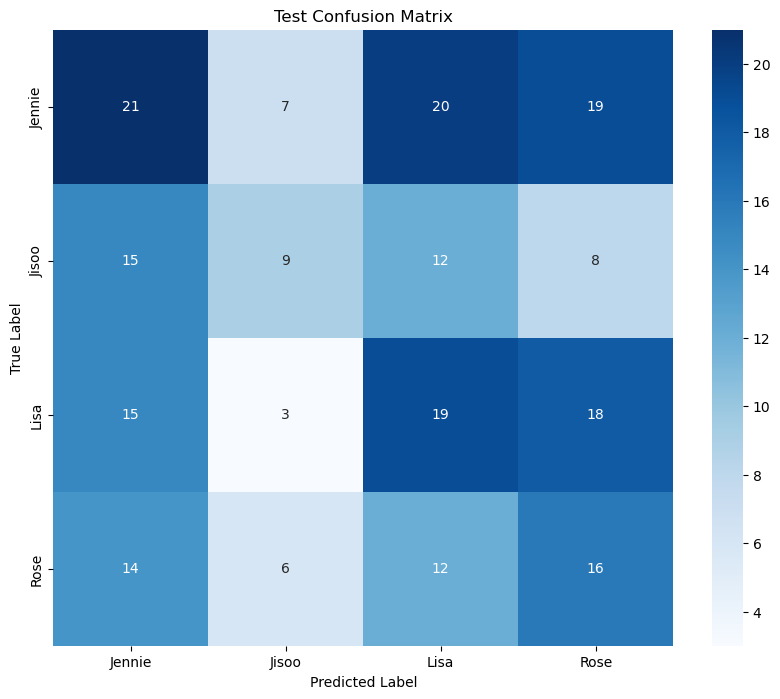


Cross-validation scores: [0.89230769 0.9025641  0.85128205 0.91794872 0.92783505]
Mean CV score: 0.8984 (+/- 0.0531)

Final Accuracies:
  Train: 0.9466
  Validation: 0.2775
  Test: 0.3037


In [168]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import torch
from torchvision import datasets, transforms

# New: Modified data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),  # New: Reduced rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # New: Reduced color jitter
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # New: ImageNet normalization
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

batch_size = 64

# Load the datasets with these transformations
data_dir = r'C:\Users\admin\Downloads\datasets-20240824T023713Z-001\datasets'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

def preprocess_data(dataloader):
    images = []
    labels = []
    for batch in dataloader:
        inputs, targets = batch
        inputs = inputs.cpu()
        targets = targets.cpu()
        images.extend(inputs.view(inputs.size(0), -1).numpy())
        labels.extend(targets.numpy())
    return np.array(images), np.array(labels)

# Preprocess all datasets
X_train, y_train = preprocess_data(dataloaders['train'])
X_val, y_val = preprocess_data(dataloaders['val'])
X_test, y_test = preprocess_data(dataloaders['test'])

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

# New: Modified LDA implementation
lda = LDA(n_components=min(num_classes - 1, 100))  # New: Limit to 100 components
X_train_lda = lda.fit_transform(X_train, y_train)
X_val_lda = lda.transform(X_val)
X_test_lda = lda.transform(X_test)

# New: Print explained variance ratio
print(f"Explained variance ratio: {sum(lda.explained_variance_ratio_):.4f}")

# New: Modified Random Forest parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                           param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train_lda, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Use the best estimator
best_rf_classifier = grid_search.best_estimator_

def evaluate_model(model, X, y, class_names, dataset_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(f"{dataset_name} Accuracy: {accuracy:.4f}")
    print(f"{dataset_name} Classification Report:")
    print(classification_report(y, y_pred, target_names=class_names))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy

# Evaluate best model after hyperparameter tuning
print("\nBest Random Forest Model Evaluation:")
train_acc_best = evaluate_model(best_rf_classifier, X_train_lda, y_train, class_names, "Train")
val_acc_best = evaluate_model(best_rf_classifier, X_val_lda, y_val, class_names, "Validation")
test_acc_best = evaluate_model(best_rf_classifier, X_test_lda, y_test, class_names, "Test")

# New: Cross-validation
cv_scores = cross_val_score(best_rf_classifier, X_train_lda, y_train, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Print accuracies
print("\nFinal Accuracies:")
print(f"  Train: {train_acc_best:.4f}")
print(f"  Validation: {val_acc_best:.4f}")
print(f"  Test: {test_acc_best:.4f}")

 ## ***LDA with Random Forest Classifier (2)***

Dataset sizes: {'train': 974, 'val': 209, 'test': 214}
Class names: ['Jennie', 'Jisoo', 'Lisa', 'Rose']
Explained variance ratio: 1.0000
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Evaluating Best Random Forest Model:
Train Accuracy: 0.9415
Train Classification Report:
              precision    recall  f1-score   support

      Jennie       0.95      0.92      0.94       305
       Jisoo       0.94      0.93      0.93       201
        Lisa       0.93      0.96      0.94       249
        Rose       0.94      0.96      0.95       219

    accuracy                           0.94       974
   macro avg       0.94      0.94      0.94       974
weighted avg       0.94      0.94      0.94       974



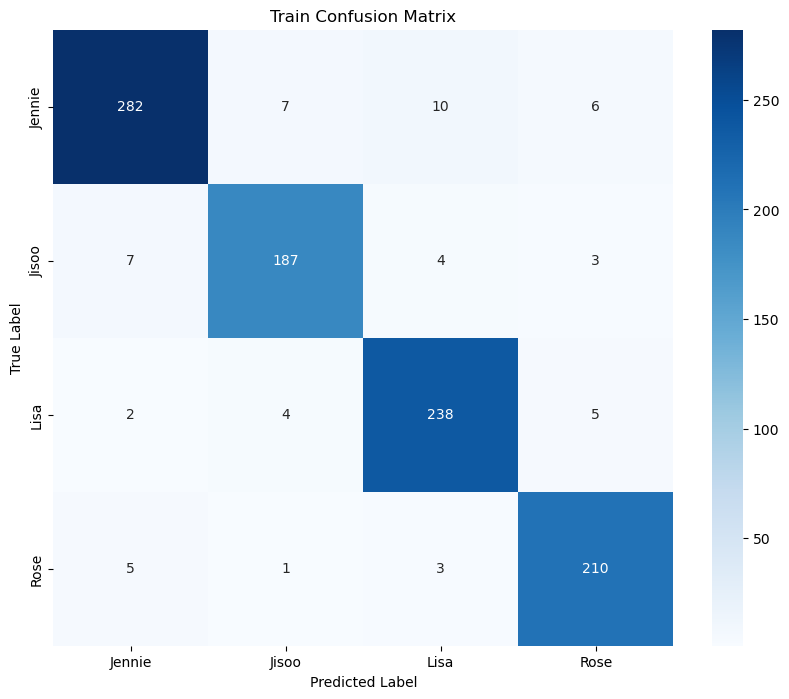

Validation Accuracy: 0.2249
Validation Classification Report:
              precision    recall  f1-score   support

      Jennie       0.26      0.14      0.18        65
       Jisoo       0.14      0.12      0.13        43
        Lisa       0.22      0.19      0.20        53
        Rose       0.25      0.48      0.33        48

    accuracy                           0.22       209
   macro avg       0.22      0.23      0.21       209
weighted avg       0.22      0.22      0.21       209



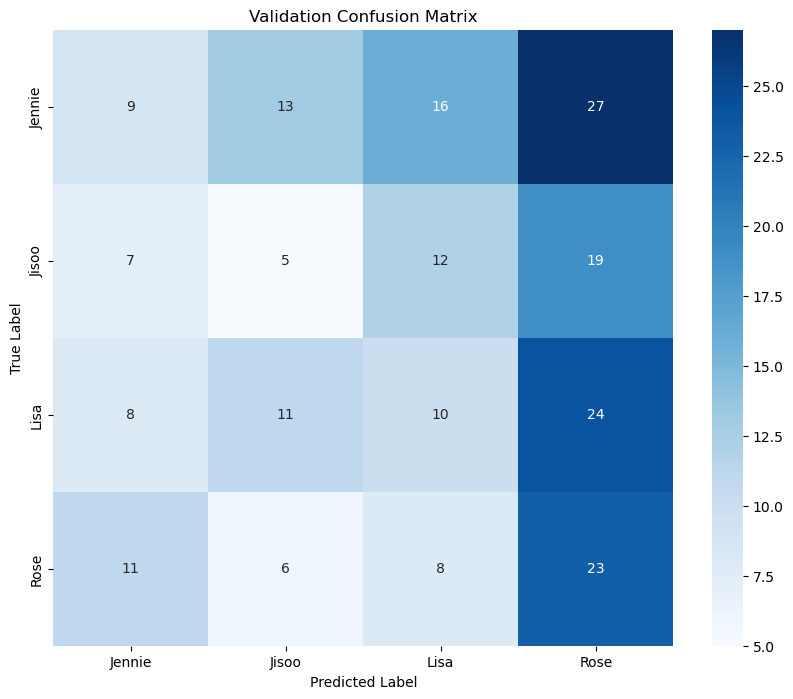

Test Accuracy: 0.3178
Test Classification Report:
              precision    recall  f1-score   support

      Jennie       0.43      0.31      0.36        67
       Jisoo       0.28      0.20      0.24        44
        Lisa       0.30      0.25      0.27        55
        Rose       0.28      0.50      0.36        48

    accuracy                           0.32       214
   macro avg       0.32      0.32      0.31       214
weighted avg       0.33      0.32      0.31       214



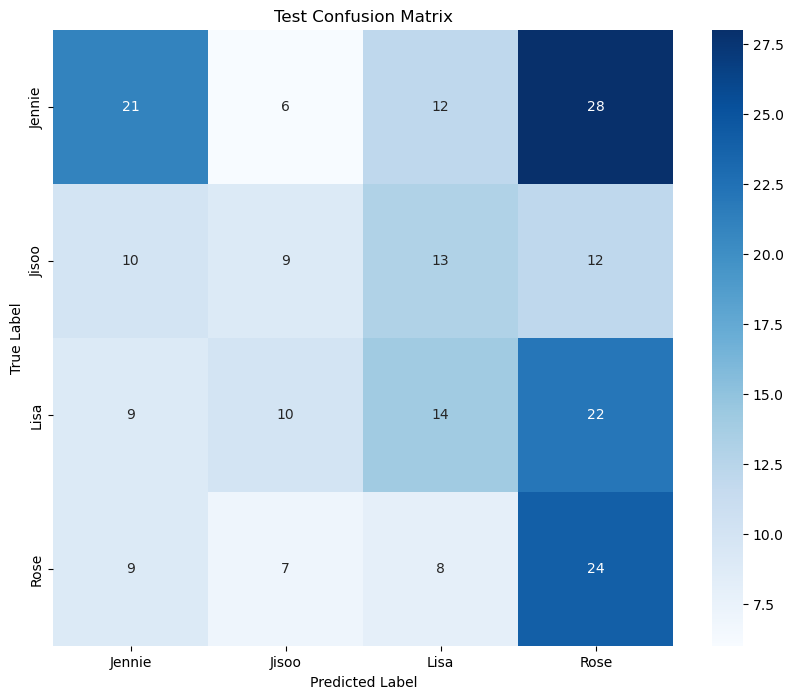


Cross-validation scores: [0.88205128 0.85641026 0.91282051 0.8974359  0.90206186]
Mean CV score: 0.8902 (+/- 0.0391)

Final Accuracies:
  Train: 0.9415
  Validation: 0.2249
  Test: 0.3178


In [261]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import torch
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler

# Data augmentation and normalization for training/validation/test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15), 
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
data_dir = r'C:\Users\admin\Downloads\datasets-20240824T023713Z-001\datasets'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

def preprocess_data(dataloader):
    images = []
    labels = []
    for batch in dataloader:
        inputs, targets = batch
        inputs = inputs.cpu()
        targets = targets.cpu()
        images.extend(inputs.view(inputs.size(0), -1).numpy())
        labels.extend(targets.numpy())
    return np.array(images), np.array(labels)

# Preprocess datasets
X_train, y_train = preprocess_data(dataloaders['train'])
X_val, y_val = preprocess_data(dataloaders['val'])
X_test, y_test = preprocess_data(dataloaders['test'])

# Normalize the data before applying LDA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply LDA
lda = LDA(n_components=len(class_names) - 1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_val_lda = lda.transform(X_val_scaled)
X_test_lda = lda.transform(X_test_scaled)

# Print explained variance ratio
print(f"Explained variance ratio: {sum(lda.explained_variance_ratio_):.4f}")

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced'],  # Handles class imbalance
    'max_features': ['sqrt', 'log2', None]
}

# Initialize and fit GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_lda, y_train)

# Use the best estimator
best_rf_classifier = grid_search.best_estimator_

# Evaluate model
def evaluate_model(model, X, y, class_names, dataset_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(f"{dataset_name} Accuracy: {accuracy:.4f}")
    print(f"{dataset_name} Classification Report:")
    print(classification_report(y, y_pred, target_names=class_names))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy

# Evaluate the model on train, validation, and test sets
print("\nEvaluating Best Random Forest Model:")
train_acc = evaluate_model(best_rf_classifier, X_train_lda, y_train, class_names, "Train")
val_acc = evaluate_model(best_rf_classifier, X_val_lda, y_val, class_names, "Validation")
test_acc = evaluate_model(best_rf_classifier, X_test_lda, y_test, class_names, "Test")

# Cross-validation
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(best_rf_classifier, X_train_lda, y_train, cv=cv)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Final accuracies
print("\nFinal Accuracies:")
print(f"  Train: {train_acc:.4f}")
print(f"  Validation: {val_acc:.4f}")
print(f"  Test: {test_acc:.4f}")


 ## ***LDA with Random Forest Classifier (3)***

Number of images in train dataset: 974
Number of images in val dataset: 209
Number of images in test dataset: 214
Dataset sizes: {'train': 974, 'val': 209, 'test': 214}
Class names: ['Jennie', 'Jisoo', 'Lisa', 'Rose']
Shape of X_train: (974, 150528)
Shape of y_train: (974,)
Shape of X_val: (209, 150528)
Shape of y_val: (209,)
Shape of X_test: (214, 150528)
Shape of y_test: (214,)
Number of classes: 4
Explained variance ratio: 1.0000
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found:  {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best score found:  0.9876923076923078

Best Random Forest Model Evaluation:
Train Accuracy: 0.9979
Train Classification Report:
              precision    recall  f1-score   support

      Jennie       1.00      1.00      1.00       305
       Jisoo       1.00      0.99      0.99       201
        Lisa       0.99      1.00      1.00       249
        Rose       1.

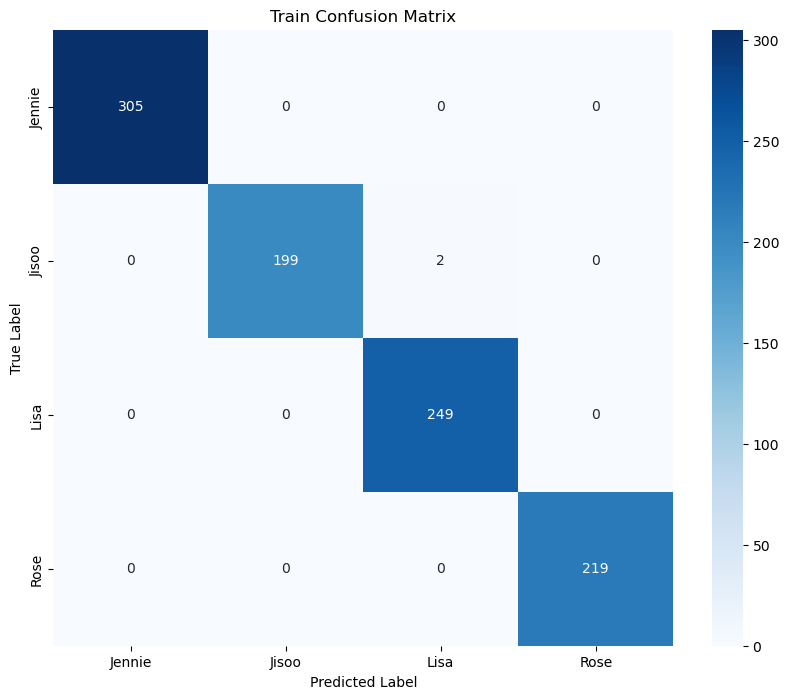

Validation Accuracy: 0.2201
Validation Classification Report:
              precision    recall  f1-score   support

      Jennie       0.27      0.09      0.14        65
       Jisoo       0.20      0.28      0.23        43
        Lisa       0.12      0.11      0.11        53
        Rose       0.30      0.46      0.36        48

    accuracy                           0.22       209
   macro avg       0.22      0.24      0.21       209
weighted avg       0.22      0.22      0.20       209



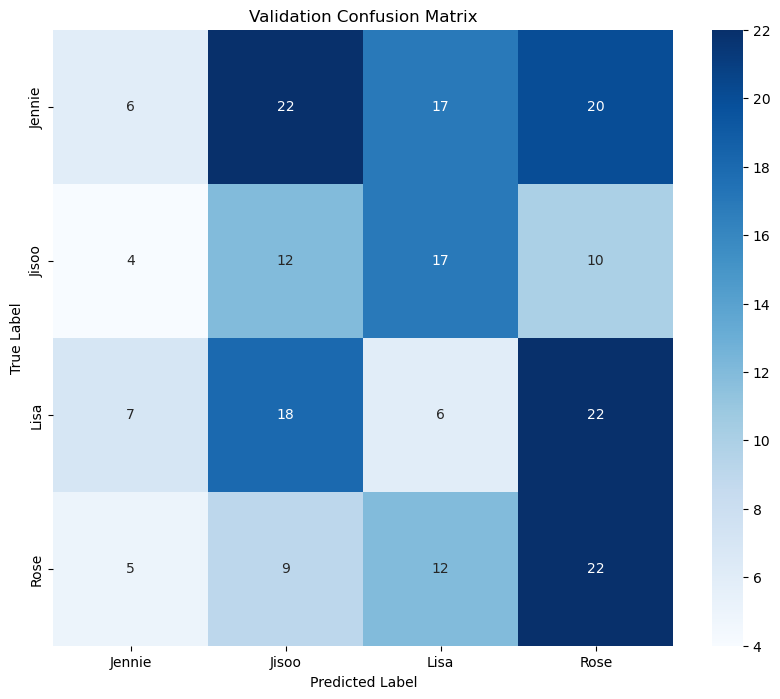

Test Accuracy: 0.2664
Test Classification Report:
              precision    recall  f1-score   support

      Jennie       0.41      0.16      0.23        67
       Jisoo       0.21      0.30      0.25        44
        Lisa       0.26      0.22      0.24        55
        Rose       0.27      0.44      0.33        48

    accuracy                           0.27       214
   macro avg       0.29      0.28      0.26       214
weighted avg       0.30      0.27      0.26       214



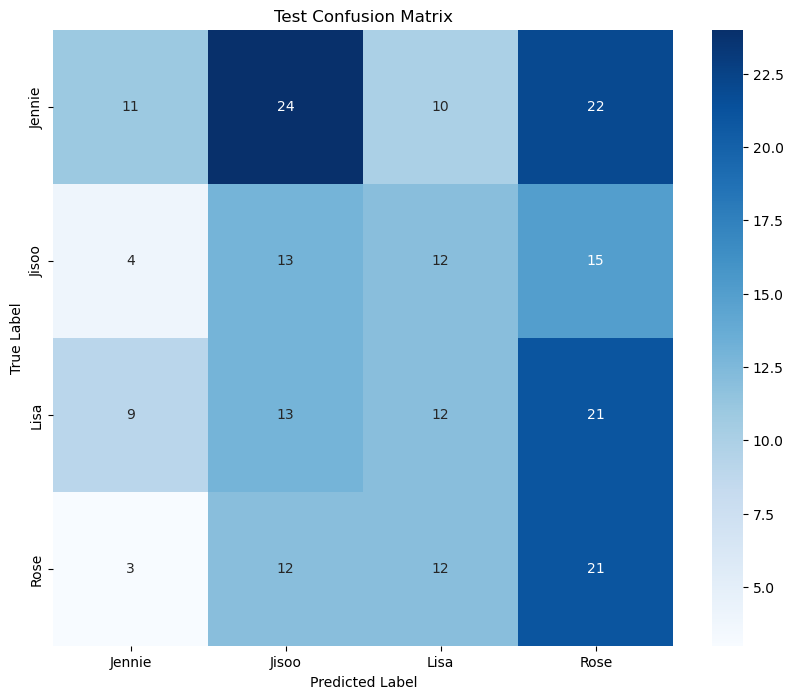


Cross-validation scores: [0.97948718 0.98974359 0.98461538 0.98461538 1.        ]
Mean CV score: 0.9877 (+/- 0.0139)

Final Accuracies:
  Train: 0.9979
  Validation: 0.2201
  Test: 0.2664


In [279]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import torch
from torchvision import datasets, transforms

# New: Modified data augmentation
data_transforms = {
    'train': transforms.Compose([
    
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),  # New: Reduced rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # New: Reduced color jitter
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # New: ImageNet normalization
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

batch_size = 64

# Load the datasets with these transformations
data_dir = r'C:\Users\admin\Downloads\datasets-20240824T023713Z-001\datasets'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

for split in ['train', 'val', 'test']:
    dataset_size = len(image_datasets[split])
    print(f"Number of images in {split} dataset: {dataset_size}")

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

def preprocess_data(dataloader):
    images = []
    labels = []
    for batch in dataloader:
        inputs, targets = batch
        inputs = inputs.cpu()
        targets = targets.cpu()
        images.extend(inputs.view(inputs.size(0), -1).numpy())
        labels.extend(targets.numpy())
    return np.array(images), np.array(labels)

# Preprocess all datasets
X_train, y_train = preprocess_data(dataloaders['train'])
X_val, y_val = preprocess_data(dataloaders['val'])
X_test, y_test = preprocess_data(dataloaders['test'])

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

# New: Modified LDA implementation
lda = LDA(n_components=min(num_classes - 1, 100))  # New: Limit to 100 components
X_train_lda = lda.fit_transform(X_train, y_train)
X_val_lda = lda.transform(X_val)
X_test_lda = lda.transform(X_test)

# New: Print explained variance ratio
print(f"Explained variance ratio: {sum(lda.explained_variance_ratio_):.4f}")

# New: Modified Random Forest parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                           param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train_lda, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Use the best estimator
best_rf_classifier = grid_search.best_estimator_

def evaluate_model(model, X, y, class_names, dataset_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(f"{dataset_name} Accuracy: {accuracy:.4f}")
    print(f"{dataset_name} Classification Report:")
    print(classification_report(y, y_pred, target_names=class_names))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy

# Evaluate best model after hyperparameter tuning
print("\nBest Random Forest Model Evaluation:")
train_acc_best = evaluate_model(best_rf_classifier, X_train_lda, y_train, class_names, "Train")
val_acc_best = evaluate_model(best_rf_classifier, X_val_lda, y_val, class_names, "Validation")
test_acc_best = evaluate_model(best_rf_classifier, X_test_lda, y_test, class_names, "Test")

# New: Cross-validation
cv_scores = cross_val_score(best_rf_classifier, X_train_lda, y_train, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Print accuracies
print("\nFinal Accuracies:")
print(f"  Train: {train_acc_best:.4f}")
print(f"  Validation: {val_acc_best:.4f}")
print(f"  Test: {test_acc_best:.4f}")

 ## ***LDA with Random Forest Classifier (4)***

Dataset sizes: {'train': 974, 'val': 209, 'test': 214}
Class names: ['Jennie', 'Jisoo', 'Lisa', 'Rose']
Explained variance ratio: 1.0000
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Evaluating Best Random Forest Model:
Train Accuracy: 0.9836
Train Classification Report:
              precision    recall  f1-score   support

      Jennie       0.99      0.97      0.98       305
       Jisoo       0.98      0.99      0.98       201
        Lisa       0.97      0.99      0.98       249
        Rose       1.00      1.00      1.00       219

    accuracy                           0.98       974
   macro avg       0.98      0.98      0.98       974
weighted avg       0.98      0.98      0.98       974



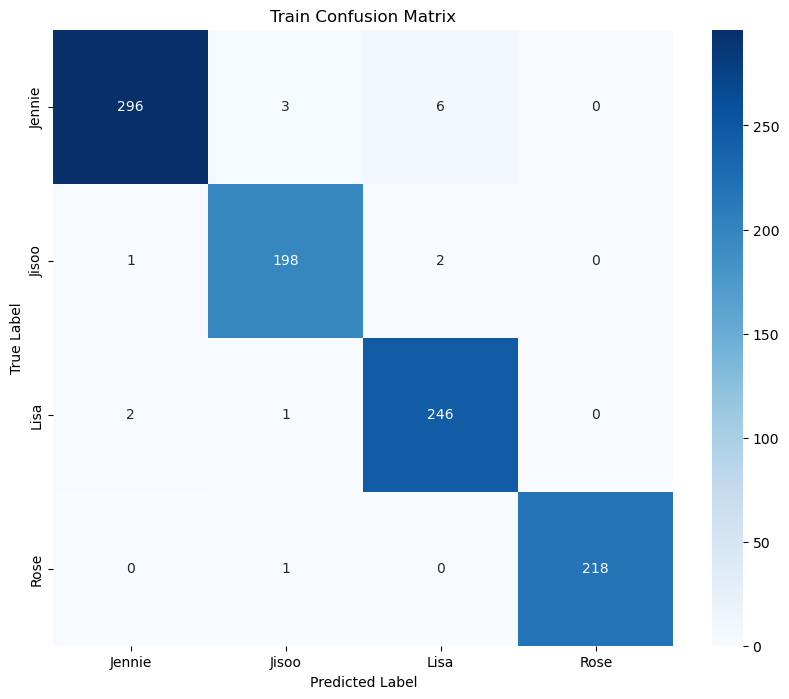

Validation Accuracy: 0.2823
Validation Classification Report:
              precision    recall  f1-score   support

      Jennie       0.41      0.25      0.31        65
       Jisoo       0.20      0.19      0.19        43
        Lisa       0.27      0.17      0.21        53
        Rose       0.27      0.54      0.36        48

    accuracy                           0.28       209
   macro avg       0.29      0.29      0.27       209
weighted avg       0.30      0.28      0.27       209



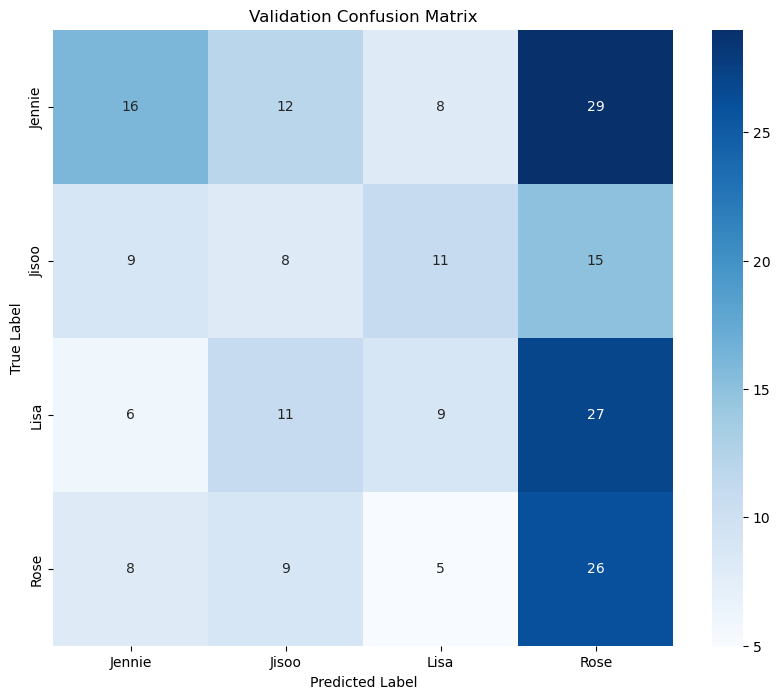

Test Accuracy: 0.3084
Test Classification Report:
              precision    recall  f1-score   support

      Jennie       0.40      0.27      0.32        67
       Jisoo       0.33      0.27      0.30        44
        Lisa       0.44      0.13      0.20        55
        Rose       0.25      0.60      0.35        48

    accuracy                           0.31       214
   macro avg       0.35      0.32      0.29       214
weighted avg       0.36      0.31      0.29       214



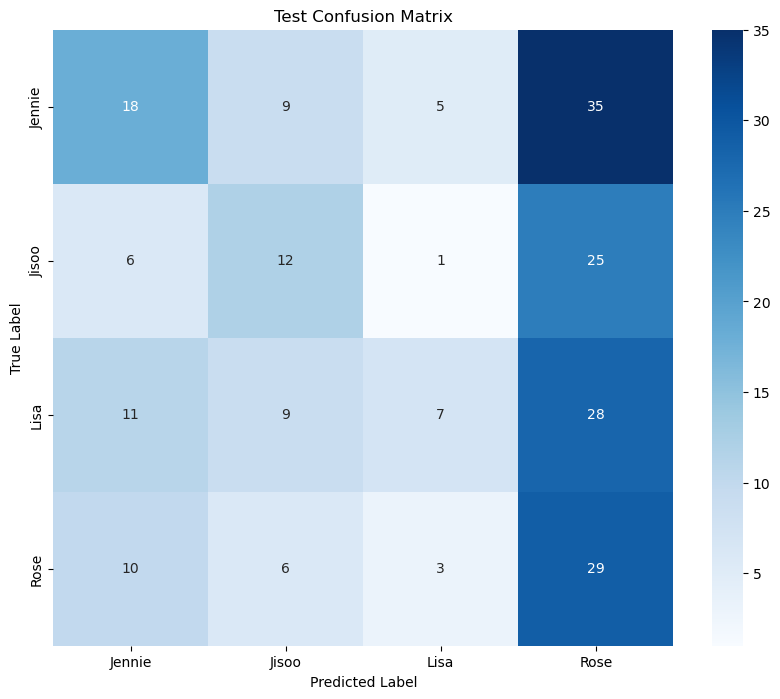


Cross-validation scores: [0.95384615 0.95384615 0.94871795 0.95384615 0.9742268 ]
Mean CV score: 0.9569 (+/- 0.0178)

Final Accuracies:
  Train: 0.9836
  Validation: 0.2823
  Test: 0.3084


In [278]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import torch
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler

# Data augmentation and normalization for training/validation/test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15), 
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
data_dir = r'C:\Users\admin\Downloads\datasets-20240824T023713Z-001\datasets'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

def preprocess_data(dataloader):
    images = []
    labels = []
    for batch in dataloader:
        inputs, targets = batch
        inputs = inputs.cpu()
        targets = targets.cpu()
        images.extend(inputs.view(inputs.size(0), -1).numpy())
        labels.extend(targets.numpy())
    return np.array(images), np.array(labels)

# Preprocess datasets
X_train, y_train = preprocess_data(dataloaders['train'])
X_val, y_val = preprocess_data(dataloaders['val'])
X_test, y_test = preprocess_data(dataloaders['test'])

# Normalize the data before applying LDA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply LDA
lda = LDA(n_components=len(class_names) - 1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_val_lda = lda.transform(X_val_scaled)
X_test_lda = lda.transform(X_test_scaled)

# Print explained variance ratio
print(f"Explained variance ratio: {sum(lda.explained_variance_ratio_):.4f}")

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced'],  # Handles class imbalance
    'max_features': ['sqrt', 'log2', None]
}

# Initialize and fit GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_lda, y_train)

# Use the best estimator
best_rf_classifier = grid_search.best_estimator_

# Evaluate model
def evaluate_model(model, X, y, class_names, dataset_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(f"{dataset_name} Accuracy: {accuracy:.4f}")
    print(f"{dataset_name} Classification Report:")
    print(classification_report(y, y_pred, target_names=class_names))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy

# Evaluate the model on train, validation, and test sets
print("\nEvaluating Best Random Forest Model:")
train_acc = evaluate_model(best_rf_classifier, X_train_lda, y_train, class_names, "Train")
val_acc = evaluate_model(best_rf_classifier, X_val_lda, y_val, class_names, "Validation")
test_acc = evaluate_model(best_rf_classifier, X_test_lda, y_test, class_names, "Test")

# Cross-validation
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(best_rf_classifier, X_train_lda, y_train, cv=cv)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Final accuracies
print("\nFinal Accuracies:")
print(f"  Train: {train_acc:.4f}")
print(f"  Validation: {val_acc:.4f}")
print(f"  Test: {test_acc:.4f}")


 ## ***LDA with Random Forest Classifier (5)***

Dataset sizes: {'train': 974, 'val': 209, 'test': 214}
Class names: ['Jennie', 'Jisoo', 'Lisa', 'Rose']
Explained variance ratio: 1.0000
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Evaluating Best Random Forest Model:
Train Accuracy: 0.9743
Train Classification Report:
              precision    recall  f1-score   support

      Jennie       0.96      0.97      0.97       305
       Jisoo       0.98      0.97      0.97       201
        Lisa       1.00      1.00      1.00       249
        Rose       0.96      0.96      0.96       219

    accuracy                           0.97       974
   macro avg       0.97      0.97      0.97       974
weighted avg       0.97      0.97      0.97       974



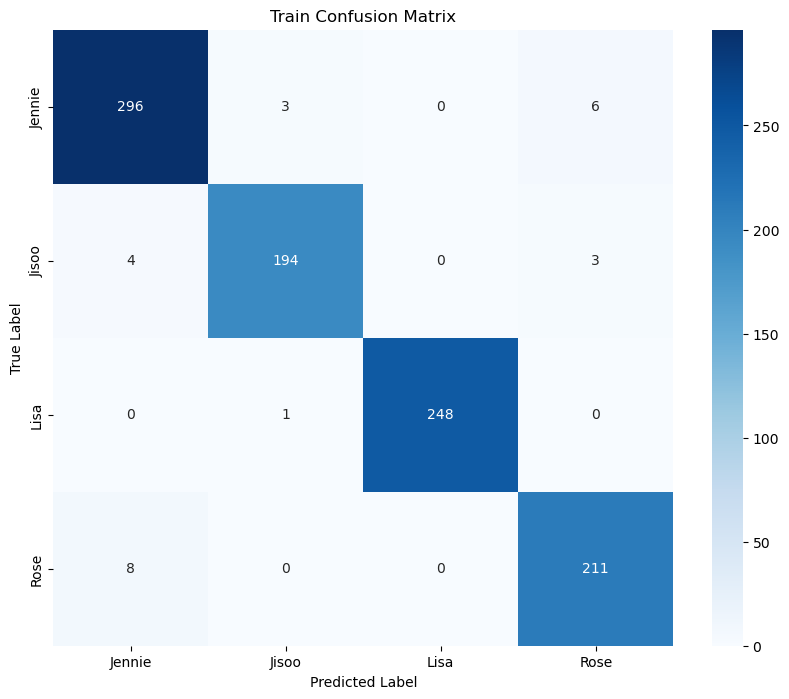

Validation Accuracy: 0.2153
Validation Classification Report:
              precision    recall  f1-score   support

      Jennie       0.12      0.03      0.05        65
       Jisoo       0.18      0.28      0.22        43
        Lisa       0.27      0.36      0.31        53
        Rose       0.22      0.25      0.23        48

    accuracy                           0.22       209
   macro avg       0.20      0.23      0.20       209
weighted avg       0.19      0.22      0.19       209



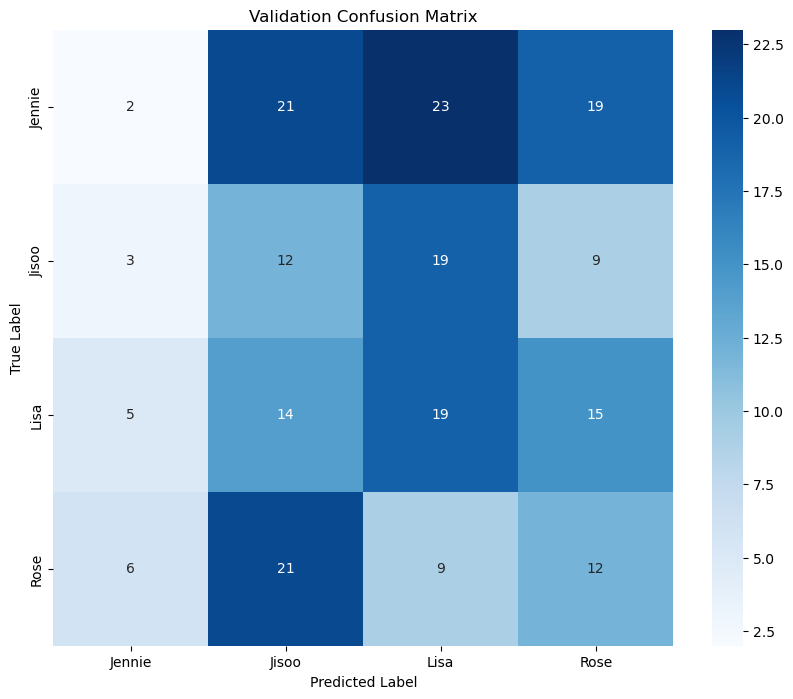

Test Accuracy: 0.2336
Test Classification Report:
              precision    recall  f1-score   support

      Jennie       0.38      0.04      0.08        67
       Jisoo       0.23      0.32      0.27        44
        Lisa       0.25      0.49      0.33        55
        Rose       0.15      0.12      0.14        48

    accuracy                           0.23       214
   macro avg       0.25      0.24      0.21       214
weighted avg       0.26      0.23      0.20       214



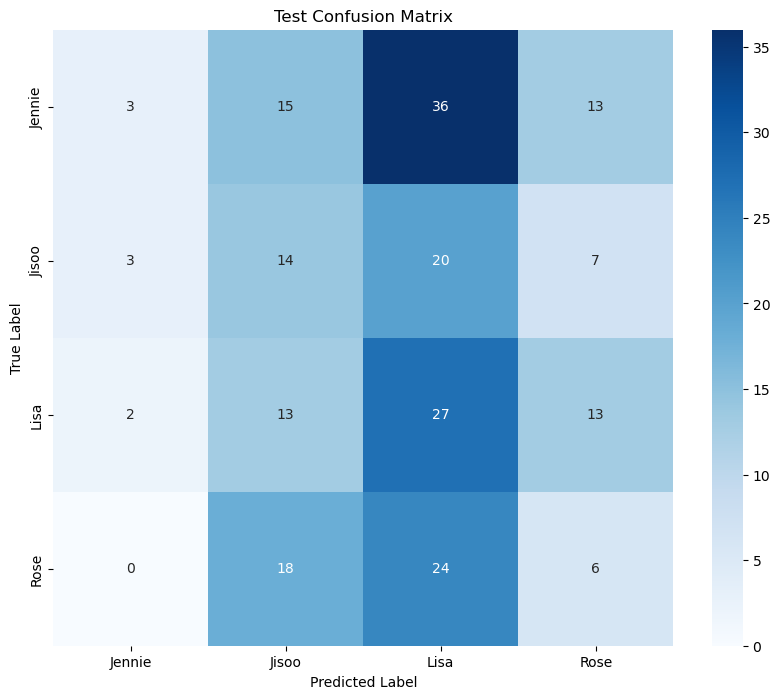


Cross-validation scores: [0.95384615 0.96410256 0.93333333 0.95384615 0.96907216]
Mean CV score: 0.9548 (+/- 0.0245)

Final Accuracies:
  Train: 0.9743
  Validation: 0.2153
  Test: 0.2336


In [351]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import torch
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler

# Data augmentation and normalization for training/validation/test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15), 
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
data_dir = r'C:\Users\admin\Downloads\datasets-20240824T023713Z-001\datasets'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

def preprocess_data(dataloader):
    images = []
    labels = []
    for batch in dataloader:
        inputs, targets = batch
        inputs = inputs.cpu()
        targets = targets.cpu()
        images.extend(inputs.view(inputs.size(0), -1).numpy())
        labels.extend(targets.numpy())
    return np.array(images), np.array(labels)

# Preprocess datasets
X_train, y_train = preprocess_data(dataloaders['train'])
X_val, y_val = preprocess_data(dataloaders['val'])
X_test, y_test = preprocess_data(dataloaders['test'])

# Normalize the data before applying LDA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply LDA
lda = LDA(n_components=len(class_names) - 1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_val_lda = lda.transform(X_val_scaled)
X_test_lda = lda.transform(X_test_scaled)

# Print explained variance ratio
print(f"Explained variance ratio: {sum(lda.explained_variance_ratio_):.4f}")

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced'],  # Handles class imbalance
    'max_features': ['sqrt', 'log2', None]
}

# Initialize and fit GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_lda, y_train)

# Use the best estimator
best_rf_classifier = grid_search.best_estimator_

# Evaluate model
def evaluate_model(model, X, y, class_names, dataset_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(f"{dataset_name} Accuracy: {accuracy:.4f}")
    print(f"{dataset_name} Classification Report:")
    print(classification_report(y, y_pred, target_names=class_names))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy

# Evaluate the model on train, validation, and test sets
print("\nEvaluating Best Random Forest Model:")
train_acc = evaluate_model(best_rf_classifier, X_train_lda, y_train, class_names, "Train")
val_acc = evaluate_model(best_rf_classifier, X_val_lda, y_val, class_names, "Validation")
test_acc = evaluate_model(best_rf_classifier, X_test_lda, y_test, class_names, "Test")

# Cross-validation
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(best_rf_classifier, X_train_lda, y_train, cv=cv)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Final accuracies
print("\nFinal Accuracies:")
print(f"  Train: {train_acc:.4f}")
print(f"  Validation: {val_acc:.4f}")
print(f"  Test: {test_acc:.4f}")
